In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Hebbian-based Maximum Eigenfilter

In this notebook we will examine an alternative approach to unsupervised learning in which a lower-dimensional representation of the data is found.
According to Oja's rule, it is possible to use a **single** linear neuron trained with Hebbian learning so that it converges to the first principal component of the data.

The output of the linear neuron is
$$y(x) = \sum_{i=1}^N \omega_i x_i = \mathbf{w}^T\mathbf{x}$$
The learning rule is
$$\mathbf{w}^{\tau+1} = \mathbf{w}^{\tau} + \eta y (\mathbf{x}-y\mathbf{w}^{\tau})$$

This is the base for the Hebbian-based Maximum Eigenfilter (HME), for which it has been proven that the vector $\mathbf{w}$ will converge to the first principal component of the data. We can create a new class with these specifications as follows:

In [2]:
class LinearHebbianNeuron:
    def __init__(self, n, w=None):
        if w is None:
            self.w = np.random.uniform(-0.5, 0.5, n)
        else:
            self.w = w
    
    def learn(self, data, lr):
        for x in data:
            y = np.dot(self.w, x)
            self.w = self.w + lr * y * (x - y*self.w)

As we can see, the learning process is dependent on the rate $\eta$ as its value will affect the convergence of the algorithm. Let's test it with a dataset taken from a two-dimensional Gaussian distribution, shown next:

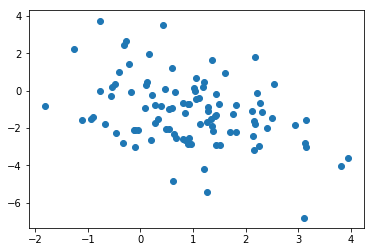

In [3]:
# Get the training data
N = 100
mu = [1,-1]
sigma = [[2, -1.0], [-1.0, 3]]
data = np.random.multivariate_normal(mu, sigma, N)
plt.scatter(data[:,0], data[:,1])
plt.rcParams["figure.figsize"] = [4,4]

We will examine the convergence, for different learning rates, of the principal component by looking at the two elements in the vector $\mathbf{w}$ separately. Additionally, we will present the data to the neuron in a "Stochastic Gradient Descent" fashion, that is, each data point will be presented once and the weights will be adjusted with it. Once the whole data set has been presented, the data is shuffled and the process is repeated for a fixed amount of iterations.

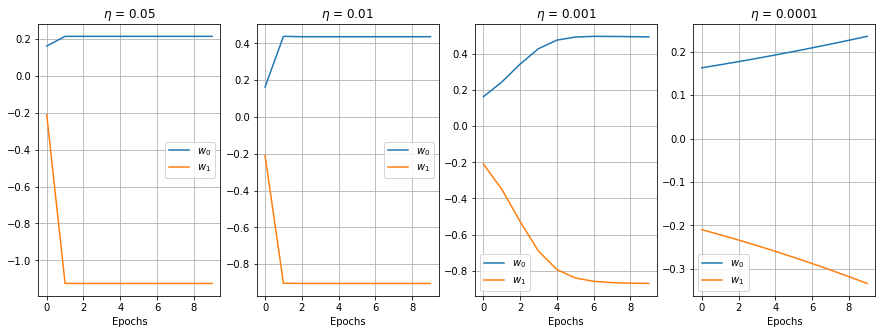

In [7]:
# The number of times the data will be shown to the neuron
epochs = 10
# A history of the weights
w_history = np.zeros((epochs, 2))

# The learning rates to examine
l_rates = [0.05, 0.01, 0.001, 0.0001]
n_rates = len(l_rates)
# For a better comparison, we initialize with the same weights
w = np.random.uniform(-0.5, 0.5, 2)

for k, lr in enumerate(l_rates):
    neuron = LinearHebbianNeuron(2, w)
    # Start learning
    for e in range(epochs):
        w_history[e,:] = neuron.w
        for i in range(N):
            neuron.learn(data[i,np.newaxis], lr)        
    
    plt.subplot(1, n_rates, k+1)
    plt.plot(w_history[:,0], label="$w_0$")
    plt.plot(w_history[:,1], label="$w_1$")
    plt.xlabel("Epochs")
    plt.legend()
    plt.title("$\eta$ = " + str(lr))
    plt.grid()
plt.rcParams["figure.figsize"] = [15,5]

We can see that indeed, the self-organizing learning algorithm converges. For high values of $\eta$ the convergence is fast but unstable, whereas for smaller values the convergence is slower but more stable. A value of 0.01 seems to produce the better tradeoff.
Once we've found the value of principal component after convergence of the HME, we can use the following functions to compare it with the true first component (obtained from the probability distribution) and the component obtained with PCA, by plotting them together with the data.

In [8]:
def first_component(A):
    """ Returns the eigenvector of the matrix A
    corresponding to the largest eigenvalue
    """
    lambdas, eigvectors = np.linalg.eig(A)
    u = eigvectors[:, np.argmax(lambdas)]
    return u    
    
def pca_first(data):
    """ Returns the first component of the data using PCA """
    mean = np.mean(data, axis=0)
    covariance = np.cov(data.T)
    return first_component(covariance)
    
def vector_line(x, u, p):
    """ Returns the data for the line y = f(x) that is
    parallel to the vector u and passes through the point p
    """
    m = u[1]/u[0]
    return m*(x-p[0]) + p[1]

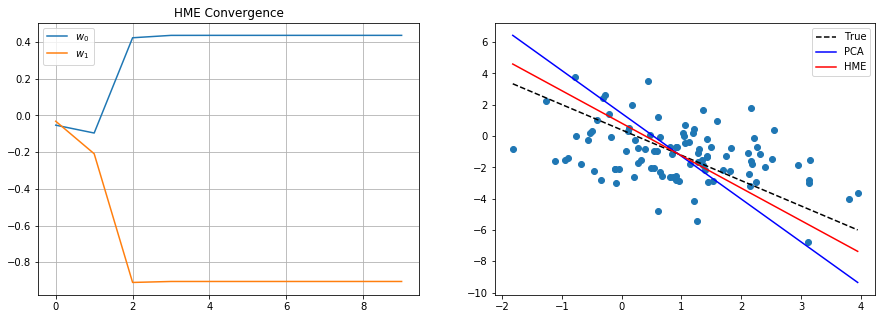

In [9]:
w_history = np.zeros((epochs, 2))
neuron = LinearHebbianNeuron(2)
for e in range(epochs):
    w_history[e, :] = neuron.w
    neuron.learn(data, lr=0.01)
    
# The true first principal component
p_t = first_component(sigma)
# The first component according to PCA
p_p = pca_first(data)
# The first component according to the HME
p_hme = neuron.w

# Plot convergence
plt.subplot(1, 2, 1)
plt.plot(w_history[:,0], label="$w_0$")
plt.plot(w_history[:,1], label="$w_1$")
plt.title("HME Convergence")
plt.legend()
plt.grid()

# Plot principal components
plt.subplot(1, 2, 2)
mean = np.mean(data, axis=0)
x = np.linspace(min(data[:,0]), max(data[:,0]))
plt.scatter(data[:,0], data[:,1])
plt.plot(x, vector_line(x, p_t, mean), "k--", label="True")
plt.plot(x, vector_line(x, p_p, mean), "b", label="PCA")
plt.plot(x, vector_line(x, p_hme, mean), "r", label="HME");
plt.legend();

We can see that the HME converges in the direction of the true first component of the data, similar to that obtained via PCA.